# **Pre Classification Analysis** 

In [ ]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing_reddit_data')

### Set file paths

In [2]:
file_path = "../../../data/labeled_data.csv"

subreddit_here = "debagree"

output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
import gurobipy
from gurobipy import *

pd.options.mode.chained_assignment = None

In [ ]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import filter_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [8]:
# import data

data = pd.read_csv(file_path)
data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...","Forensic Audit: ""We conclude that the Dominion...",Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics it’s wrong this ...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42889,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42890,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42891,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42892,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a $1200 package until the GOP ...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for $2000 in direct checks,...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


1
1842
word_count
1       66629
150     18577
13       6655
15       6625
12       6622
        ...  
1524        1
1414        1
1389        1
1409        1
1369        1
Name: count, Length: 1382, dtype: int64


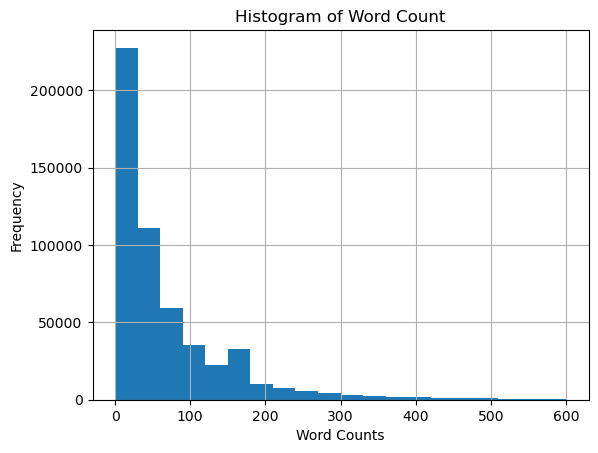

In [ ]:
# later: count submission, comment, reply text length

df_comments_replies["tokens"] = df_comments_replies["body"].apply(lambda x: x.split())
df_comments_replies["word_count"] = df_comments_replies["tokens"].apply(len)

print(df_comments_replies['word_count'].min())
print(df_comments_replies['word_count'].max())
print(df_comments_replies['word_count'].value_counts())

fig, ax = plt.subplots()
ax.hist(df_comments_replies['word_count'], bins = 20, range = (0, 600))
ax.set_title("Histogram of Word Count")
#ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) 
#ax.set_xticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"])  
ax.set_xlabel("Word Counts")
ax.set_ylabel("Frequency")
ax.grid(True)

### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

--> all already done in debagree paper

### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 



--> same, already done by debagree 


### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [14]:
data['body_parent'].value_counts().head(15)
data['body_child'].value_counts().head(15)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
Your post or comment has been removed for violating: - Rule 2 (Remember the people) It is unacceptable to refer to a group by a derogatory term. Do not categorise all pro-Leave supporters as racists or bigots etc. Do not categorise all pro-Remain supporters as remoaners or snowflakes etc.                                                                                                          10
It's not about the chlorine. It's never been about the chlorine. The chlorine is only there because they found an easy way to cut costs. By lowering animal welfare standards, they get issues which can be covered with a chlorine treatment. Simple as that. So by pushing for chlorine chicken, they want to open a market where the cost of chicken is higher, and compete with... lower standards.     4
Brush your teeth! And don't forget to floss after each meal. That's hella important yo. Also, wash your ass. It's hot outside. Swamp ass is no joke. Don't be scared to use soap. Get all up in t

In [13]:
df = preprocess_texts(data = data, length = 5, threshold_child = 2, threshold_parent = 20)
df

Length 5 removes 14 interactions


,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42810,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42811,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42812,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


In [15]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [20]:
for words in df['body_parent'].sample(10):
    print(words)

for words in df['body_child'].sample(10):
    print(words)



51 days until we have to process the first of many illegal refugees coming into Calais. This time from the north. Oh well, the French have experience with all that.
The point here is, both sides largely dont want violence, while recognising there are a small number that do. We can pretend the minority enjoying the idea of violence is the majority, or recognise them as the crazy subset they are.
So. For this to happen we need agreements for quicker data exchange. And when we exchange data, you store our data according to our regulations. And do not share it with your US buddies again! Oh? You do not want to follow our regulations? Make your own laws? What a bummer!
How does the OP feel about the trillion dollar a year deficit Trump gave us, to fund his tax cuts for the rich....in the best economy ever?
So what? None of the candidates in the primary other than Bernie filled giant stadiums and that's because his base was younger and more energized. Don't make the mistake of thinking that 

In [21]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42810,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42811,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42812,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


***
## **Descriptive Stats**

In [24]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

63102
Unique Users:  51209


### Time Stats and originally pulled counts

In [25]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2012-12-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 47176
Number of comments and replies: 532593
---------------------------------------------



### Descriptive Stats after Matching

In [26]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  70108
Number of unique comments:  44111
Number of unique submissions:  12341


### Descriptive Stats after cleaning for high quality texts

In [27]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))

Unique Replies:  53779
Unique Comments:  35544
